# TP 1 Big Data : Risque empirique/ Risque de population

# Dani Halegua, Luca Champesting et Idyano Leroy


#### Le compromis entre complexité des modèles et nombre de données est au centre de la problématique de l'apprentissage statistique. Dans ce TP, nous allons illustrer cette problématique sur un problème jouet de reconnaissance de forme
#### Le but de ce TP est d'implémenter en python le calcul de $\hat C_p$ et mesurer la différence avec entre le risque $R_{emp}(\mathbb{1}_{\hat C_p})$ évalué sur l'échantillon et le risque de population $R(\mathbb{1}_{\hat C_p})$

On dispose des données suivantes :
 - $f_{g,s}(x) = \sum_{i=1}^{n} exp (-\frac {|x-g_i|^2}{2 s_i^2}) $
 - $ A = \left\{  x \in [0,1]^2 | f_{g,s}(x) > \frac {1} {2} \right\} $
 - $ (g_i)_{1 \leq i \leq n} $ tirés au hasard uniformément dans le carré $[0.2,0.8] ^2 $
 - $ (s_i)_{1 \leq i \leq n} $ tirés au hasard uniformément dans l'intervalle $[0,a] $

(1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def f(g,s,x1,x2):                                       #Définit la fonction f
    x=[x1,x2]
    n=g.shape[0]
    somme=0
    for i in range(n):
        somme += np.exp(-((np.linalg.norm(x-g[i]))**2)/(2*(s[i])**2))
    return somme
       

def isinA (g,s,x1,x2):                   #Pour savoir si un point x appartient à A
    if f(g,s,x1,x2) > 0.5 :
        return 1
    else:
        return -1
    

def intens(x1,x2,g,s):
    Y = []
    for i in range (len(x1)):
        Y += [isinA(g,s,x1[i],x2[i])]
    return Y

In [4]:
a=0.3
n=4
g=np.random.uniform(0.2,0.8,(n,2))
s=np.random.uniform(0,a,n)
x1=[0.4,0.8,0.87,0.76,0.99]
x2=[0.4,0.09,0.87,0.76,0.01]
intens(x1,x2,g,s) #test de la fonction intens

[1, -1, -1, -1, -1]

(2)

In [5]:
def ensalea(n,a,flag):
    g=np.random.uniform(0.2,0.8,(n,2))
    s=np.random.uniform(0,a,n)
    if flag == 1:
        xx=np.linspace(0,1,50)       #on quadrille le carré 
        yy=np.linspace(0,1,50)
        plt.figure(figsize=(12,12))
        for i in tqdm ( xx )  :
            for j in yy :
                if (isinA(g,s,i,j)) == 1 :   #si un point appartient à A, on l'affiche en rouge, sinon on l'affiche en bleu
                    plt.scatter( i ,j , color = 'r' , linewidth = 2 )
                else : 
                    plt.scatter( i , j , color = 'b' , linewidth = 2 )
        plt.show()
    return g,s

(3)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


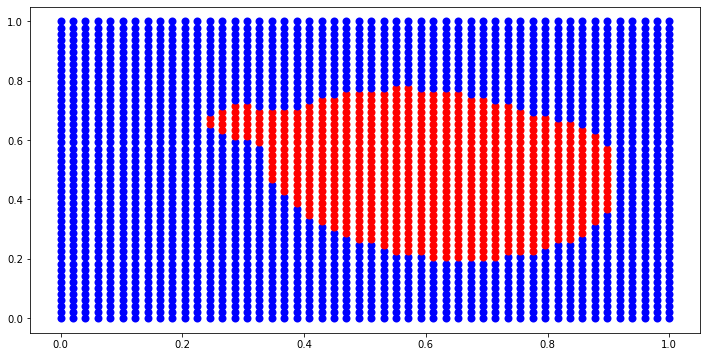

In [6]:
a=0.3
n=4

g,s = ensalea(n,a,1)

(4)

In [7]:
def echant(l,g,s):
    x=np.random.uniform(0,1,(l,2))
    x1=x[:,0]
    x2=x[:,1]
    Y = intens(x1,x2,g,s)
    return x1,x2,Y

(5)

In [8]:
def isinC_ij(x1,x2,i,j,p):                                      #Pour savoir si un point appartient au carreau C_ij
    x,y = x1,x2
    if ((i-1)/p <= x) and (x<= i/p) and ((j-1)/p <= y) and (y<= j/p) :
        return 1
    else :
        return 0
    
    
def L_ij(X1,X2,Y,i,j,p):                                         #Calcule le l+ et l- pour un carreau C_ij donné
    l_plus = 0
    l_moins = 0
    for k in range (len(X1)):
        if (isinC_ij(X1[k],X2[k],i,j,p) == 1) and (Y[k] == 1):
            l_plus += 1
        elif (isinC_ij(X1[k],X2[k],i,j,p) == 1) and (Y[k] == -1):
            l_moins += 1
    return l_plus, l_moins

La fonction ```estens``` renvoie une matrice B contenant tous les $p^2$ carreaux et permet de trouver tous les $c_{ij}$ carreaux qui participent à la construction de $\hat C_p$. En effet, B(i,j) = 1 si $c_{ij} \in  \hat C_p$ et =0 sinon. La fonction renvoie également le risque $\hat R^*_p$ associé à $\hat C_p$. Ainsi, sur l'échantillon test, on prédira 1 si le $X'_i \in \hat C_p$ et 0 sinon.

In [9]:
def estens(X1,X2,Y,p):                 
    risque = 0
    B = np.zeros((p,p))
    l = len(X1)
    for i in range (p):
        for j in range(p):
            l_plus, l_moins = L_ij(X1,X2,Y,i+1,j+1,p)
            if (l_plus >= l_moins) :
                B[i,j] = 1
                risque += l_moins
            else : 
                B [i,j] = 0
                risque += l_plus
    risque /= l
    return  B, risque

(6) On peut maintenant construire la fonction ```testens``` qui va utiliser l'échantillon d'apprentissage pour prédire sur l'échantillon test et ainsi calculer le risque $R_{test} (\mathbb {1} _{\hat C_p})$ associé. Ce risque test va approximer le vrai risque $R (\mathbb {1} _{\hat C_p})$ à partir d'une certaine taille $m= \lceil-\frac {log(0.05/2)} {2*0.02^2}\rceil$

In [11]:
def testens(B,m,g,s):
    X1,X2,Y = echant(m,g,s)
    p=B.shape[0]
    risque = 0
    for i in range(p):
        for j in range(p):
            if B[i,j]==1:
                risque += L_ij(X1,X2,Y,i+1,j+1,p)[1]
            else:
                risque += L_ij(X1,X2,Y,i+1,j+1,p)[0]
    risque /= m
    return risque
                
            

(7)

In [58]:
def affichage_erreur(l):
    m=int(np.ceil(-(np.log(0.05/2))/(2*(0.02)**2)))
    X1,X2,Y = echant(l,g,s)
    Rp = []
    Rtest = []
    for p in range (2,60):
        B,R = estens(X1,X2,Y,p)
        Rp += [R]
        Rtest += [testens(B,m,g,s)]
    
    pmin = Rtest.index(min(Rtest))  + 2
    print("Pour l = {} le p optimal vaut {}".format(l,pmin))
    plt.plot(np.arange(2,60),Rp, label = ' Empirique')
    plt.plot(np.arange(2,60),Rtest, label = ' Test')
    plt.title("l = {}".format(l) )
    plt.legend()
    plt.show()

Pour l = 100 le p vaut optimal 5


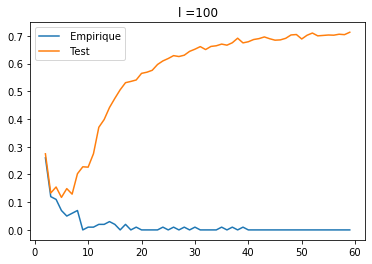

In [59]:
affichage_erreur(100)

Pour l = 500 le p vaut optimal 9


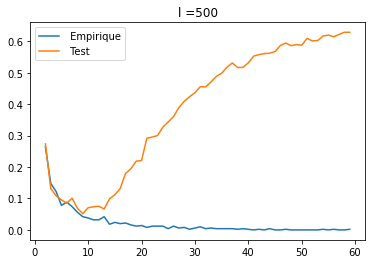

In [60]:
affichage_erreur(500)

Pour l = 1000 le p vaut optimal 12


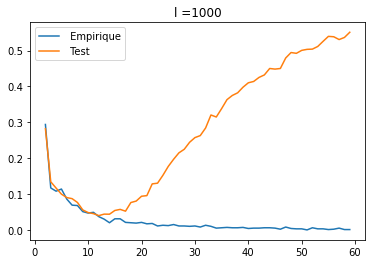

In [72]:
affichage_erreur(1000)

Pour l = 10000 le p vaut optimal 36


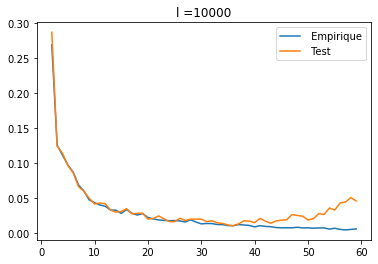

In [73]:
affichage_erreur(10000)

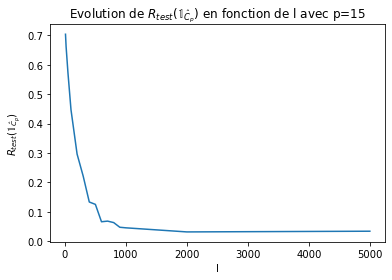

In [66]:
#On fixe p= 15

p=15
lst=[10,20,50,100,200,300,400,500,600,700,800,900,1000,2000,5000]
m=int(np.ceil(-(np.log(0.05/2))/(2*(0.02)**2)))
Rtest = []

for l in lst:
    X1,X2,Y = echant(l,g,s)
    B,R = estens(X1,X2,Y,p)
    Rtest += [testens(B,m,g,s)]

plt.plot(lst,Rtest)
plt.xlabel("l")
plt.ylabel("$R_{test} (\mathbb {1} _{\hat C_p})$")
plt.title("Evolution de $R_{test} (\mathbb {1} _{\hat C_p})$ en fonction de l avec p=15")
plt.show()
    


Pour p=15, on constate un "coude" aux alentours de l=1000, cela signifie que le l optimal à choisir est de 1000, l'augmenter ne servirait à rien et le diminuer donnerait de moins bons résultats.

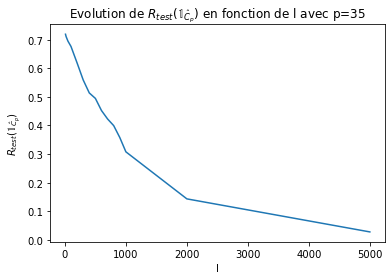

In [71]:
p = 35
Rtest =[]
for l in lst:
    X1,X2,Y = echant(l,g,s)
    B,R = estens(X1,X2,Y,p)
    Rtest += [testens(B,m,g,s)]

plt.plot(lst,Rtest)
plt.xlabel("l")
plt.ylabel("$R_{test} (\mathbb {1} _{\hat C_p})$")
plt.title("Evolution de $R_{test} (\mathbb {1} _{\hat C_p})$ en fonction de l avec p=35")
plt.show()
    

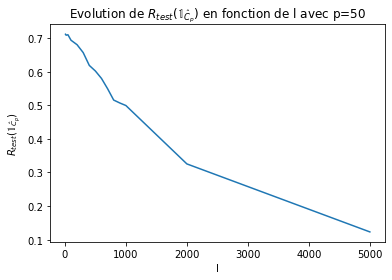

In [68]:
p = 50
Rtest =[]
for l in lst:
    X1,X2,Y = echant(l,g,s)
    B,R = estens(X1,X2,Y,p)
    Rtest += [testens(B,m,g,s)]

plt.plot(lst,Rtest)
plt.xlabel("l")
plt.ylabel("$R_{test} (\mathbb {1} _{\hat C_p})$")
plt.title("Evolution de $R_{test} (\mathbb {1} _{\hat C_p})$ en fonction de l avec p=50")
plt.show()
    


Pour p=50, il faut un l>5000, pour obtenir les meilleurs résultats possibles.

**8) Commentaires :**

 $\hat{R}_p^*$ représente le risque défini par la fonction de perte sur notre échantillon d'entrainement et $R_{test}(1_{\hat{C}_p})$ représente le risque sur un échantillon test qui approxime $R(1_{\hat{C}_p})$

- **l’évolution des deux courbes à $l$ fixé, $p$ variant :**

On voit que le risque empirique $\hat{R}_p^*$ tend vers 0 lorsque $p$ augmente, ce qui est normal car plus $p$ est grand, plus notre modèle aura une subdivision très fine et alors on aura très peu d'erreur sur l'échantillon d'apprentissage.

Par contre, pour l'échantillon de test, une subdivision très fine du carré veut dire que les carreaux vont parfaitement coller aux données d'apprentissage mais ne vont pas pouvoir se généraliser aux données de l'échantillon test, on parle de sur-apprentissage. Ainsi, à partir d'un certain $\hat p$, la courbe $R_{test}(1_{\hat{C}_p})$ augmentera.


- **l’évolution de $\hat{p}$ en fonction de $l$ :**

$\hat{p}$ représente le $p$ qui minimise $R_{test}(1_{\hat{C}_p})$

On remarque que plus le nombre d'échantillon d'apprentissage $l$ est grand, plus $\hat{p}$ devient grand. C'est à dire, que plus on a de données d'entrainement, plus on doit augmenter la complexité ($p$) du modèle, pour avoir le modèle qui généralise le mieux. 

- **l'évolution de $R_{test}(1_{\hat{C}_p})$ en fonction de $l$, à $p$ fixé :**
A $p$ fixé, on observe que $R_{test}(1_{\hat{C}_p})$ décroît jusqu'à un certain $l$, à partir duquel il commence à stagner. Plus notre modèle est complexe ($p$ est grand), plus le $l$ optimal augmente.

**En particulier comment cette expérience illustre**
- **le compromis entre complexité des modèles et taille de l’échantillon d’apprentissage :**

La complexité du modèle est liée à $p$ et la taille de l'échantillon est $l$

Cette expérience nous permet de voir qu'on doit prendre en compte la taille de l'échantillon d'apprentissage pour choisir la compléxité du modèle. Puisqu'un modèle trop complexe vis à vis de la taille de l'échantillon d'apprentissage ne pourra pas généraliser sur les nouvelles données test, on parle alors de sur-apprentissage (over-fitting). Au contraire, un modèle pas assez complexe vis à vis de la taille de l'échantillon d'apprentissage ne pourra pas apprendre correctement, le modèle est alors biaisé et on parle de sous-apprentissage (under-fitting). Ce compromis entre compléxité du modèle et taille de l'échantillon d'apprentissage est connu sous le nom de compromis biais-variance.


- **la consistance de la minimisation du risque empirique sur la famille $\mathcal{F}_p$ :**

Pour $p\in[0,60]$, on a bien la consistance de la minimisation du risque empirique, c'est à dire, plus $l$ est grand, plus  $\hat{R}_p^*$ est proche de $R_{test}(1_{\hat{C}_p})$. On le voit surtout quand on passe de $l=1000$ à $l=10000$.